# Time Series Forcasting with a Linear Regression Model

In [30]:
import pandas as pd
with open("../data/measurements.json") as file:
    df = pd.read_json(file)

In [31]:
df['measuredAt'] = pd.to_datetime(df['measuredAt'])
df.index = df['measuredAt']
del(df['measuredAt'])

In [32]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

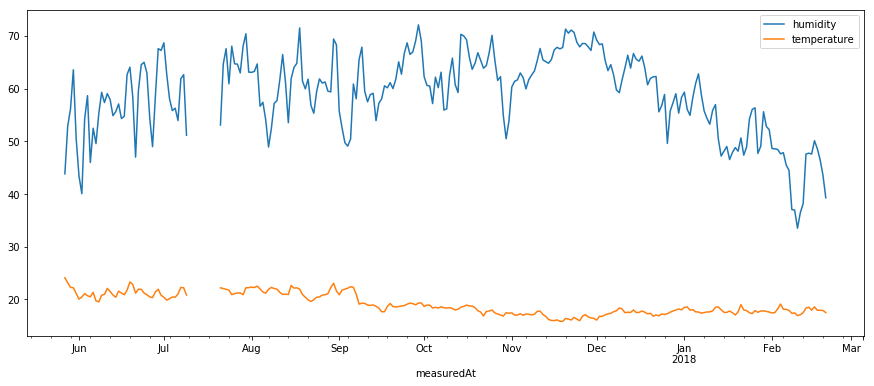

In [33]:
df.resample('D').mean().plot()

In [34]:
df.index

DatetimeIndex(['2018-02-20 19:00:08.145411', '2018-02-20 18:00:09.190775',
               '2018-02-20 17:00:10.197395', '2018-02-20 16:00:08.208562',
               '2018-02-20 15:00:08.232641', '2018-02-20 14:00:07.085685',
               '2018-02-20 13:00:07.137441', '2018-02-20 12:00:10.179205',
               '2018-02-20 11:00:12.220128', '2018-02-20 10:00:09.715086',
               ...
               '2017-05-27 22:00:40.576659', '2017-05-27 21:00:09.525139',
               '2017-05-27 20:00:10.138441', '2017-05-27 19:00:13.771968',
               '2017-05-27 18:40:53.500771', '2017-05-27 18:35:47.109730',
               '2017-05-27 18:00:17.092384', '2017-05-27 17:23:30.756653',
               '2017-05-27 17:19:42.369249', '2017-05-27 16:11:57.235106'],
              dtype='datetime64[ns]', name='measuredAt', length=6138, freq=None)